In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from  process import *

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

In [4]:
from sklearn.metrics import mean_squared_error

In [5]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
train = pd.read_parquet(Path('../data/preprocessed/adv_train.pq'))
test = pd.read_parquet(Path('../data/preprocessed/adv_test.pq'))

In [9]:
train1 = joblib.load(Path('../data/preprocessed/train_pred1.bin'))
train2 = joblib.load(Path('../data/preprocessed/train_pred2.bin'))
test1 = joblib.load(Path('../data/preprocessed/pred1.bin'))
test2 = joblib.load(Path('../data/preprocessed/pred2.bin'))

In [11]:
train['rbrt'] = train1
train['rbrt_sent'] = train2
test['rbrt'] = test1
test['rbrt_sent'] = test2

In [12]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [14]:
train_n = train.drop(columns=DROP_FEATURES)
test_n = test.drop(columns=DROP_FEATURES)

In [15]:
X_train, X_val = train_test_split(train_n.drop(columns=['id']), train_size=0.7, random_state=42)

In [16]:
train_pool = Pool(X_train.drop(columns=['salary']), np.log(X_train['salary']+1), cat_features=CAT_FEATURES)

In [17]:
val_pool = Pool(X_val.drop(columns=['salary']), np.log(X_val['salary']+1), cat_features=CAT_FEATURES)

In [18]:
params = {'bagging_temperature': 0.0,
 'depth': 10,
 'iterations': 100,
 'learning_rate': 0.26561363291515183,
 'min_child_samples': 70,
 'random_strength': 0.9115570762733113,
 'reg_lambda': 6.953237326616156}

In [19]:
est = CatBoostRegressor(**params)

In [20]:
est.fit(train_pool, eval_set=val_pool, verbose_eval=10)

0:	learn: 1.0681439	test: 1.0602426	best: 1.0602426 (0)	total: 318ms	remaining: 31.5s
10:	learn: 1.0024959	test: 1.0011934	best: 1.0011934 (10)	total: 1.7s	remaining: 13.8s
20:	learn: 0.9927869	test: 0.9974205	best: 0.9974205 (20)	total: 2.91s	remaining: 10.9s
30:	learn: 0.9857126	test: 0.9953646	best: 0.9953568 (29)	total: 4.12s	remaining: 9.17s
40:	learn: 0.9803520	test: 0.9947290	best: 0.9947290 (40)	total: 5.4s	remaining: 7.77s
50:	learn: 0.9772439	test: 0.9946704	best: 0.9946344 (45)	total: 6.48s	remaining: 6.22s
60:	learn: 0.9765471	test: 0.9947576	best: 0.9946344 (45)	total: 7.39s	remaining: 4.72s
70:	learn: 0.9733233	test: 0.9946372	best: 0.9946278 (68)	total: 8.68s	remaining: 3.55s
80:	learn: 0.9701483	test: 0.9946015	best: 0.9945817 (79)	total: 9.95s	remaining: 2.33s
90:	learn: 0.9651916	test: 0.9944808	best: 0.9943872 (83)	total: 11.4s	remaining: 1.13s
99:	learn: 0.9605822	test: 0.9943131	best: 0.9942698 (97)	total: 12.8s	remaining: 0us

bestTest = 0.9942697745
bestIteration

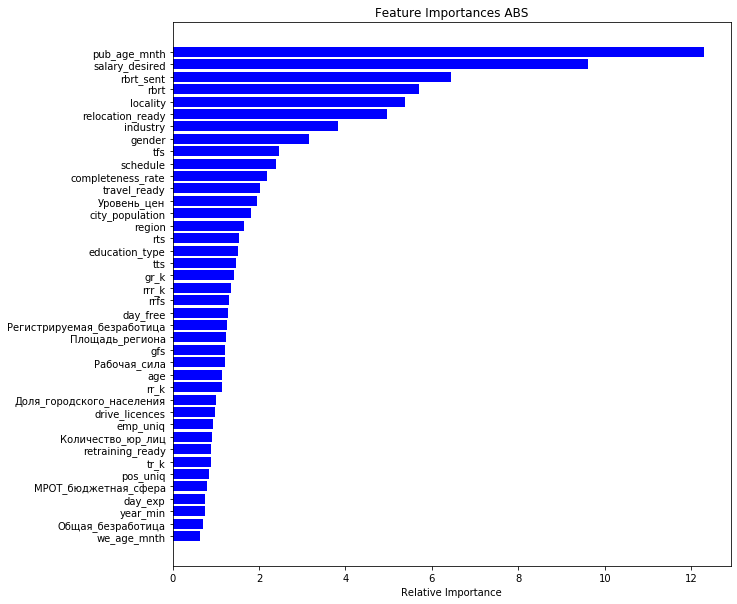

In [21]:
importance = sorted(zip(X_train.drop(columns=['salary']).columns, est.feature_importances_), key=lambda x: x[1], reverse=True)
imp = list(reversed(importance[:40]))
plt.figure(figsize=(10,10))
plt.title('Feature Importances ABS')
plt.barh(range(len(imp)), [x[1] for x in imp], color='b', align='center')
plt.yticks(range(len(imp)), [x[0] for x in imp])
plt.xlabel('Relative Importance')
plt.show()

In [22]:
np.sqrt(mean_squared_log_error(X_val['salary'], np.exp(est.predict(val_pool))-1))

0.994269774210631

0.997859426677459

In [23]:
np.sqrt(mean_squared_log_error(X_train['salary'], np.exp(est.predict(train_pool))-1))

0.9629831716427769

0.9645155233472713

In [24]:
est.fit(train_n.drop(columns=['id', 'salary']), 
        np.log(train_n['salary']+1), 
        verbose_eval=10,
       cat_features=CAT_FEATURES)

0:	learn: 1.0653311	total: 253ms	remaining: 25s
10:	learn: 1.0023800	total: 2.38s	remaining: 19.3s
20:	learn: 0.9919128	total: 4.13s	remaining: 15.5s
30:	learn: 0.9868294	total: 5.64s	remaining: 12.6s
40:	learn: 0.9839606	total: 7.09s	remaining: 10.2s
50:	learn: 0.9791609	total: 9.01s	remaining: 8.66s
60:	learn: 0.9768040	total: 10.7s	remaining: 6.86s
70:	learn: 0.9756037	total: 12.9s	remaining: 5.25s
80:	learn: 0.9717974	total: 15s	remaining: 3.51s
90:	learn: 0.9689604	total: 17.1s	remaining: 1.69s
99:	learn: 0.9670999	total: 19s	remaining: 0us


In [25]:
np.sqrt(mean_squared_log_error(train_n['salary'], 
                               np.exp(est.predict(train_n.drop(columns=['id', 'salary'])))-1))

0.9672233924966293


0.9679435998332367

In [26]:
predict=np.exp(est.predict(test_n.drop(columns=['id'])))-1

In [27]:
sub = test_n[['id']].copy()

In [28]:
sub['salary'] = predict

In [29]:
sub.to_csv(Path('../submissions/cb_5_ho_btrs_sub.csv'), index=False, sep=",")